In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

In [2]:
%matplotlib inline

### Create DLA algorithm for 2D Matrix
- Here point aggregator is simulated
- additional funtion `DLA2D.trace_point()` is provided to trace the attachment of each point to graph
**pseudocode**

```
dla{
    initialize the matrix with needed parameter
    mark the start point
    generate a random point
    while (point not attached to adjacent)
        random walk around adjacent
    }
```

**Write-up**
- This is the simulation of DLA for **point aggregator**. We start by defining some the parameters like `matrix_size`, `stickiness` and `point_to_generate`. As defined in `DLA2d.__init__()`
- After defining our matrix, we initialize all pixels with `0` and mark the center with a pixel value of `255`. As defined in `DLA2d.initialize_matrix()`
- The next step is iterative and all these steps are preformed inside the method `DLA2d.generate_dla()`. This iteration stops after all the `points_to_generated` are exhausted. But before we also create an matrix `visit_matrix`. This makes sure that walk is only performed on the positions where the specific point has never walked and thus put to check on infinite walk.
    * Generate a random position in the matrix using method `DLA2d.get_random_pos()` with a conditional check that already pixelated value of 255 is not selected.
    * Once we have a position, mark the location in `visit_matrix` and check if its attaching with any adjacent points using method `DLA2d.check_attachment()`.
        * If the current position's adjacent doesn't has a pixel value of 255 then do a random walk using `DLA2d.start_random_walk()` along the adjacent point generated using `DLA2d.get_adjacent_points()`
        * keep doing the above statement till there is an attachment with adjacent checked with method `DLA2d.check_attachement()`. Keeping a condition check that during each random walk it should choose an adjacent point which has not been visited yet.
    * All the paths taken by the point after a random point is generated at start is kept inside the member `DLA2d.path` 
        
**extra**
- An additional method `DLA2d.trace_point()` has been created to see the trace of path taken by a point throughout its journey.

In [3]:
class DLA2d:
    def __init__(self, matrix_size: int, stickiness: float, points_to_generate: int):
        """Declaration of matrix for DLA

        Parameters
        ----------
        matrix_size : int
        size of the matrix
        stickiness : float
        attaching probabilty of points to each other
        points_to_generate : int
        total points to attach to each other
        """
        self.matrix_size = matrix_size
        self.stickiness = stickiness
        self.points_to_generate = points_to_generate
    
    def initialize_matrix(self):
        """Initialize the matrix with empty pixel value except the center
        """
        matrix = np.zeros((self.matrix_size, self.matrix_size), dtype=np.int32)
        # point aggregator
        matrix[self.matrix_size//2, self.matrix_size//2] = 255
        return matrix
    
    def get_adjacent_points(self, pos: tuple, padding: bool=True) -> list:
        """Generate the adjacent points from a position

        ```
            example:
                0 X X X 0
                0 X - X 0
                0 X X X 0
        ```

        Parameters
        ----------
        pos : tuple
        x,y coordinate of the current position 
        padding : bool, optional
            If the position of point is at edges then look at other edge.
            ex: if point leaves leave left, it should enter from right and if it leaves from top,
            it must enter from bottom. (Vice versa), by default True

        Returns
        -------
        list
            adjacent coordinates
        """
        x, y = pos
        adjacent_pos = [
            (x - 1, y - 1),
            (x - 1 if x-1 > -1 else self.matrix_size-1, y) if padding else (x - 1, y), #up
            (x - 1, y + 1),
            (x, y - 1 if y-1 > -1 else self.matrix_size-1) if padding else (x, y - 1), # left
            (x, y + 1 if y+1 < self.matrix_size else 0) if padding else (x, y + 1), # right
            (x + 1, y - 1),
            (x + 1 if x+1 < self.matrix_size else 0, y) if padding else (x +1, y), # down
            (x + 1, y + 1)]
        adjacent_pos = filter(
            lambda x: (x[0] > -1 and x[0] < self.matrix_size) and (x[1] > -1 and x[1] < self.matrix_size),
            adjacent_pos)
        return list(adjacent_pos)
    
    def get_random_pos(self, matrix: np.ndarray) -> tuple:
        """Generate a random position within array

        Parameters
        ----------
        matrix : np.ndarray
            matrix from where a position will be selected

        Returns
        -------
        tuple
            position(x,y), probability of selecting the position.
        """
        new_pos = (self.matrix_size//2, self.matrix_size//2)
        while matrix[new_pos]==255:
            new_pos = tuple(np.random.randint(0, self.matrix_size, size=2))
        return new_pos, 1
    
    def start_random_walk(self, pos: tuple) -> tuple:
        """Do a random walk along the current position

        Parameters
        ----------
        pos : tuple
            The current position along which a random walk will be done to
            its adjacent's point

        Returns
        -------
        tuple
            new position, probabilty of selecting the point
        """
        # S(t) = S(t-1) + w(t)
        # w(t) is chosen from adjacent points with a probablistic inference from the distribution
        # TODO: Optimize the walk
        adj_pos = self.get_adjacent_points(pos)
        idx = np.random.randint(len(adj_pos))
        prob = 1/len(adj_pos)
        return adj_pos[idx], prob
    
    def check_attachment(self, pos: tuple, prob: float, matrix: np.ndarray) -> bool:
        """Checking if the position is attaching to its adjacent.

        Parameters
        ----------
        pos : tuple
            current position
        prob : float
            probability of the selected position
        matrix : np.ndarray
            matrix containing points

        Returns
        -------
        bool
            True, if its attaching to adjacent.

        .. note::
            Here adjacent points from the current position are looked with the padding. Ie. Adjacent
            points are not looked beyond the edge.
        """
        adjacent = self.get_adjacent_points(pos, padding=False)
        return any(filter(lambda x: matrix[x]==255, adjacent)) and prob < self.stickiness
    
    def generate_dla(self, matrix: np.ndarray) -> np.array:
        """Runner method for simulation of DLA

        Parameters
        ----------
        matrix : np.ndarray
            Initialized matrix with only 1 point as starter

        Returns
        -------
        np.array
            Plotted matrix with all the points attached to each other
        """
        self.path = []
        for point in tqdm(range(self.points_to_generate)):
            point_path = []
            visit_matrix = np.zeros((self.matrix_size, self.matrix_size), dtype=np.int32)
            new_pos, prob = self.get_random_pos(matrix)
            visit_matrix[new_pos] = 1
            point_path.append(new_pos)
            while not self.check_attachment(new_pos, prob, matrix):
                while visit_matrix[new_pos]==1:
                    new_pos, prob = self.start_random_walk(new_pos)
                point_path.append(new_pos)
                visit_matrix[new_pos] = 1
            matrix[new_pos] = 255
            self.path.append(point_path)
        del visit_matrix
        return matrix
    
    def trace_point(self, point: int) -> int:
        """This is an additional method to trace the path of point in its journey
        before attaching to a point

        Parameters
        ----------
        point : int
            point whose path needs to be traced upon.

        Returns
        -------
        int
            if 0, issue in generating plot else 1
        """
        data = np.empty((self.matrix_size, self.matrix_size), dtype=np.int32)
        data.fill(255)
        data[self.matrix_size//2, self.matrix_size//2] = np.random.randint(255)
        if point < len(self.path) and point > 0:
            for i in range(point):
                data[self.path[i][-1]] = np.random.randint(255)
            fig = plt.figure(figsize=(30, 30))
            ax = plt.axes(xlim=(0, self.matrix_size), ylim=(0, self.matrix_size))

            #plot the attached point/pixels till the recent point
            ax.imshow(data.transpose(), interpolation='nearest', cmap='gray')

            #mark the trace
            trace = self.path[point-1]
            x, y = trace[0]
            x_, y_ = trace[-1]

            #start marker
            ax.scatter(x, y, marker='*', s=20*2*6, c='#17202A')

            #end marker
            ax.scatter(x_, y_, marker='*', s=20*4*6, c='#f20c27')

            #trace curve
            X, Y = zip(*trace)
            line, = ax.plot(X, Y, lw=2, color='#0492C2')
            ax.set_xticks(np.arange(0, self.matrix_size, 20))
            ax.set_yticks(np.arange(0, self.matrix_size, 20))
            ax.set_title('Random walk (Point Aggregator)', fontsize=22)
            ax.set_xlabel('X-coordinate', fontsize=18)
            ax.set_ylabel('Y-coordinate', fontsize=18)
            ax.tick_params(labelsize=16)
            return 1
        else:
            print("Point number exceeds/underweighs points present in the matrix.")
            return 0

## Task 1: Simulation of DLA for a given value of stickiness.

In [4]:
new_dla = DLA2d(matrix_size=50, stickiness=1, points_to_generate=100)
new_matrix = new_dla.initialize_matrix()
mod_matrix = new_dla.generate_dla(matrix=copy.deepcopy(new_matrix))

100%|██████████| 100/100 [00:02<00:00, 44.93it/s]


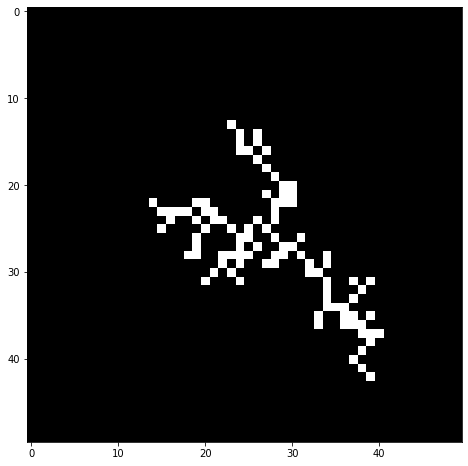

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(mod_matrix, cmap = 'gray')

1

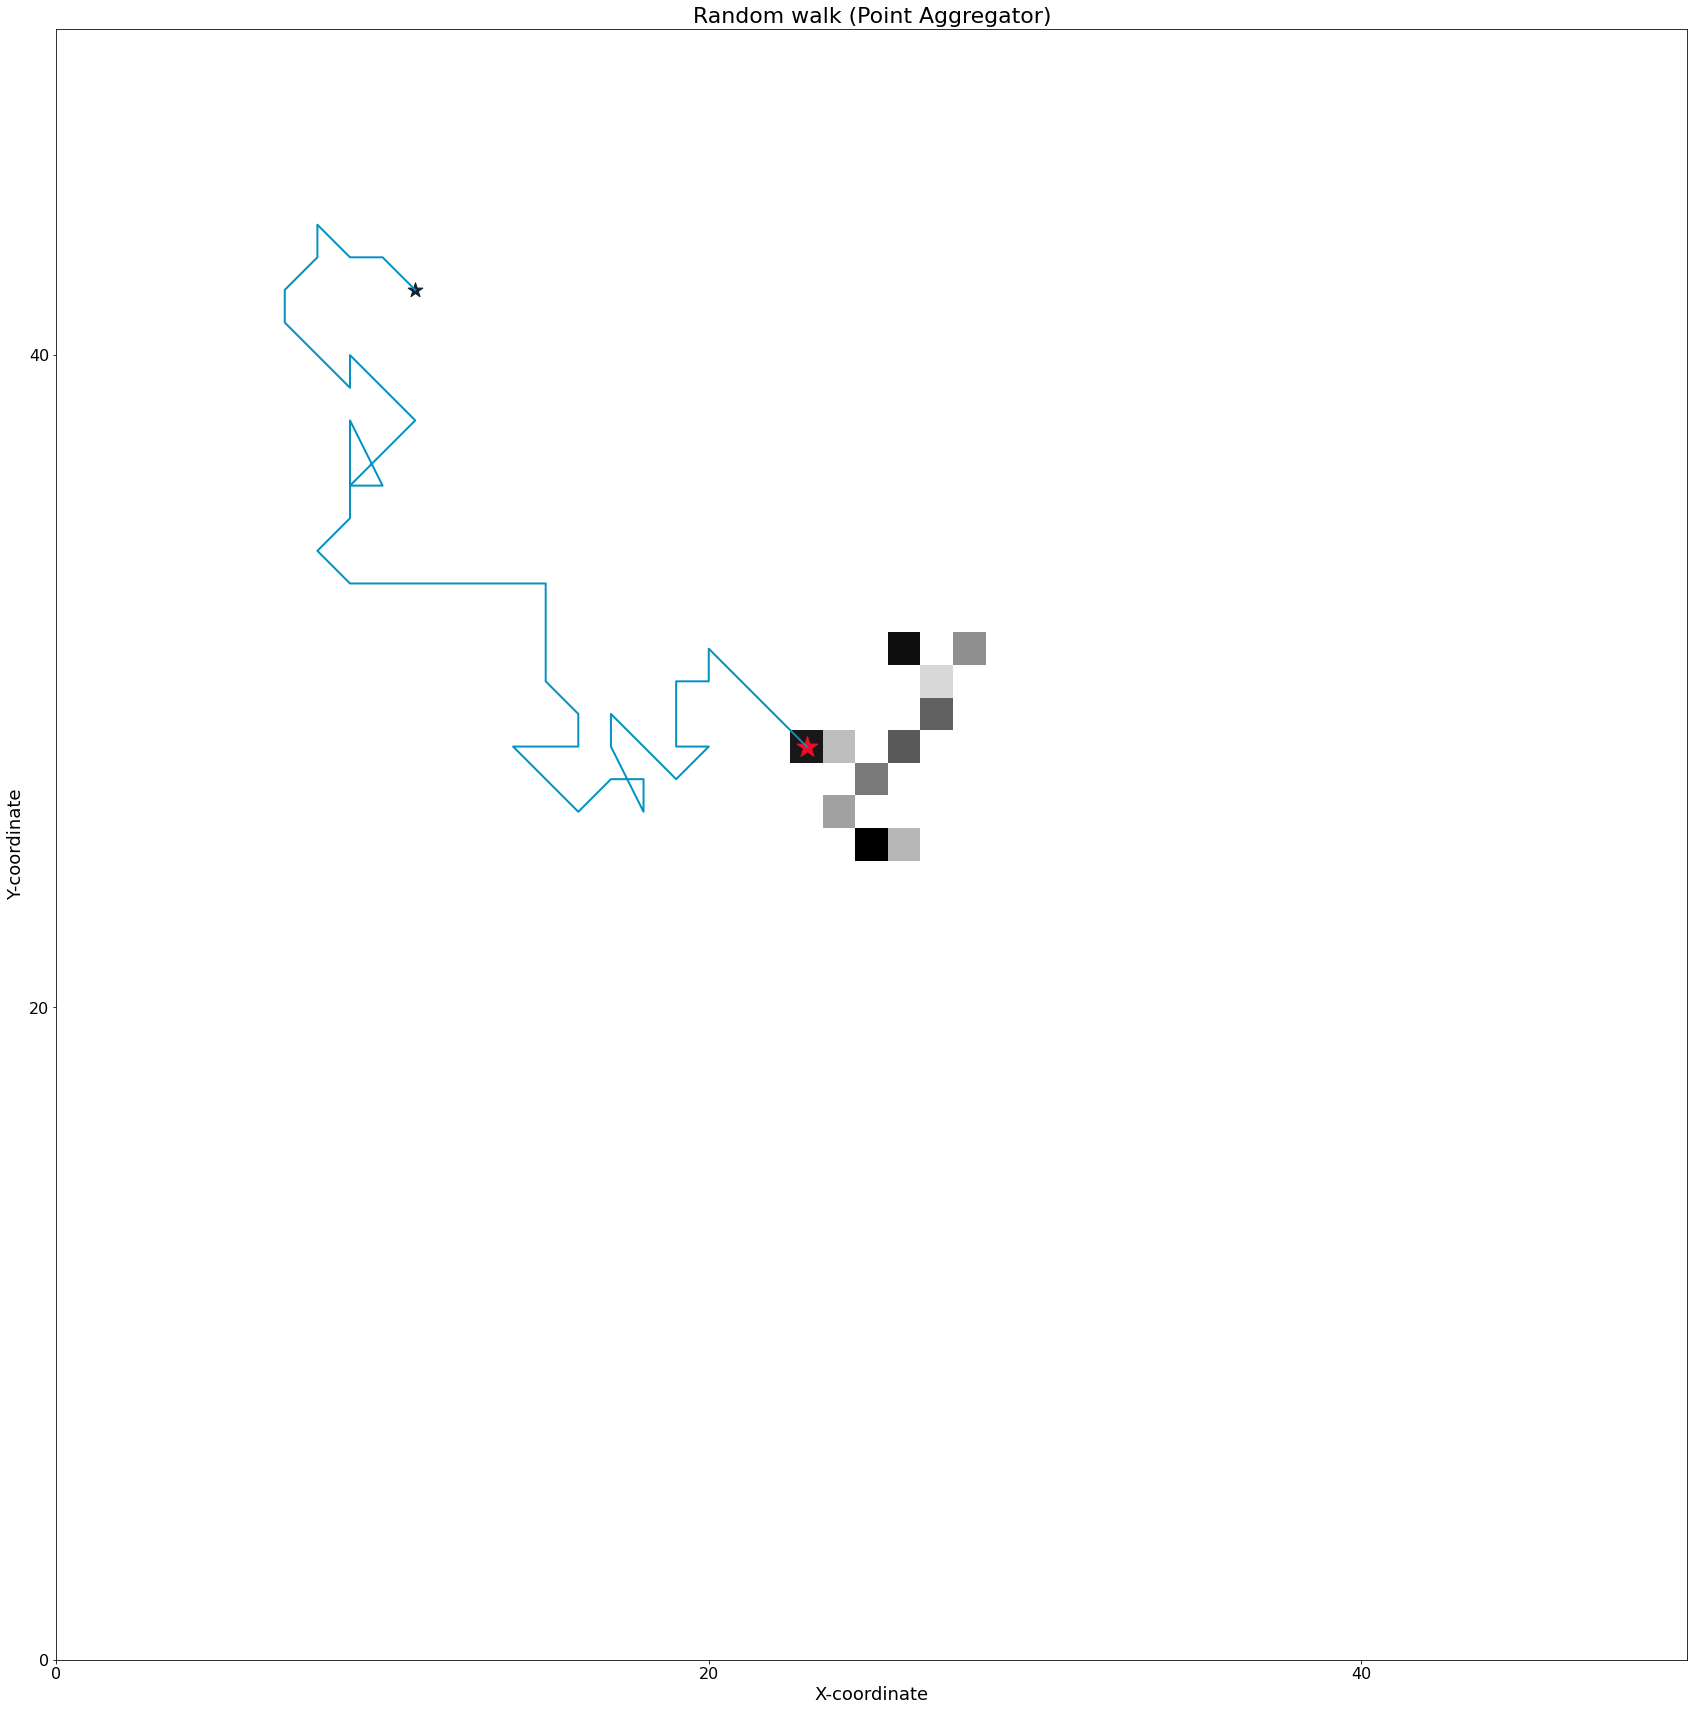

In [9]:
new_dla.trace_point(point=10)

## Task 2: An algorithm to estimate the "stickiness" parameter

In [10]:
import os
import re
from PIL import Image
from typing import Union

### Create a helper module to generate dataset for estimating stickiness

**pseudocode**

```
InferImage{
    read the image/matrix n x n
    take a filter m x m at center #As this is a point aggregator
    Slice the matrix of shape m x m
    calculate
        surface area of m x m
        crowd density of m x m
        total point used on matrix n x n
```
- use `DLA2d` to create an image and the user `InferImage` to get the remaining datapoint
- generate the dataset

**Write-up**
- Reading of the output image/matrix of DLA simulation is done and a `InferImage.filter_size` is created of size `m X m`. This `m` is calculated of 60% of length of DLA simulated matrix.
- Slice the `InferImage.image` of m X m from center. Use this sliced image to calculate the density and surface area of the spread of the points attached in that region.
- generate the dataset and then use a regression model to calculate `stickiness`

In [11]:
class InferImage:
    def __init__(self, image:Union[np.ndarray, str]):
        if isinstance(image, str):
            img = Image.open(image)
            img = img.convert("L")
            self.image = np.array(img)
        else:
            self.image = copy.deepcopy(image)
            self.filter_size = int(self.image.shape[0] * 0.6)
        
    def sliced_matrix(self):
        if self.filter_size <= self.image.shape[0]:
            middle_point = self.image.shape[0]//2
            half_filter_size = self.filter_size//2
            a = middle_point-half_filter_size
            b = middle_point+half_filter_size + 1
            return self.image[a:b, a:b]
        raise ValueError("Reduce filter size")
        
    def get_surface_area(self, matrix):
        return np.count_nonzero(matrix)
    
    def get_crowd_density(self, matrix):
        return self.get_surface_area(matrix)/(matrix.shape[0]**2)

The datase contains the following information:

**Given an image and filter size, all can be calculated.**

| Image | filter size | surface area | Crowd density of points | Total points used | Stickiness |
|-------|-------------|--------------|-------------------------|-------------------|------------|

- Image: Point aggregator image generated from the above algorithm
- filter size: filter matrix to crop image around center
- surface area: surface area of pixel in the filter area
- crowd density: crowd density of the points in the filter area
- Total points used: Total points used for the generation of image
- Stickiness: probablity with which a point is getting attached to another point

In [12]:
# save the dataset as a pandas dataframe
# define the dataset headers
if not os.path.exists('dataset.pkl'):
    print("File doesn't exists. Creating a new file.")
    dataset = pd.DataFrame(columns=[
        'Image', 'filter size', 'surface area',
        'Crowd density of points', 'Total points used', 'Stickiness'])
    dataset.to_pickle("dataset.pkl")
else:
    dataset = pd.read_pickle("dataset.pkl")

In [13]:
# save the generated images at directory image_save_path
image_save_path = './Image/'
if not os.path.exists(image_save_path):
    print("Directory not present. Creating a new one.")
    os.mkdir(image_save_path)

In [14]:
# Create 1000 runs each time and the corresponding generated images are kept inside .Image/ dir
initial_runs = 0
if not dataset.empty:
    initial_runs = max(map(int, dataset['Image'].str.extract(pat=r'(\d+)', expand=False))) + 1
    print("{} images have aleady been generated.".format(initial_runs))
runs = 1000 + initial_runs
print("New images are to be generated with prefix starting from {} to {}".format(initial_runs, runs))

84 images have aleady been generated.
New images are to be generated with prefix starting from 84 to 1084


In [ ]:
# Run the loop to generate the data and change the matrix size after frequency of 100
# change the matrix size after 100th run
matrix_size = 40
for run in range(initial_runs, runs):
    k = np.random.uniform(0.01, 1)
    dla = DLA2d(
        matrix_size=matrix_size,
        stickiness = k,
        points_to_generate = np.random.randint(matrix_size, 100))
    new_matrix = dla.initialize_matrix()
    mod_matrix = dla.generate_dla(matrix=new_matrix)
    file_name = image_save_path + "run_{}.png".format(run)
    plt.imsave(file_name, mod_matrix)
    
    infer = InferImage(image=mod_matrix)
    total_point = infer.get_surface_area(mod_matrix)
    slc_matrix = infer.sliced_matrix()
    surface_area = infer.get_surface_area(slc_matrix)
    crowd_density = infer.get_crowd_density(slc_matrix)
    
    dataset = dataset.append(
        {'Image': file_name,
         'filter size': infer.filter_size,
         'surface area': surface_area,
         'Crowd density of points': crowd_density,
         'Total points used': total_point,
         'Stickiness': dla.stickiness
        }, ignore_index=True
    )
    dataset.to_pickle("dataset.pkl")
    if run % 100 == 0:
        print("Run: {} completed.".format(run))
        matrix_size = matrix_size + 10
        print("new matrix({0}X{0})".format(matrix_size))
    del dla, infer, new_matrix, mod_matrix, slc_matrix

### Subtask: A basic regression model to check the hypothesis
**Use a regression model to predict the stickiness in an image.**
- Provided an image, surface area, Crowd density of points, Total points used can be calculated for a given filter size. Using them a value can be predicted as a stickiness parameter

In [15]:
dataset = pd.read_pickle("dataset.pkl")
dataset.set_index("Image", inplace=True)

In [16]:
print(len(dataset))

84


In [17]:
dataset.head(2)

,filter size,surface area,Crowd density of points,Total points used,Stickiness
Image,,,,,
./Image/run_0.png,24,86,0.13760,90,0.525142
./Image/run_1.png,30,68,0.07076,68,0.638705


In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

In [19]:
scaler = MinMaxScaler()
data = scaler.fit_transform(dataset)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size=0.3)

In [21]:
reg = svm.SVR(kernel='poly', verbose=True)

In [22]:
reg.fit(x_train, y_train)

[LibSVM]

SVR(kernel='poly', verbose=True)

In [23]:
# r2 coefficient
reg.score(x_test, y_test)

-0.49935857440609266

In [24]:
pd.DataFrame({'predicted': reg.predict(x_test), 'actual': y_test, 'Error_2': (y_test - reg.predict(x_test))**2})

,predicted,actual,Error_2
0,0.509393,0.907612,0.158579
1,0.763672,0.313040,0.203070
2,0.499537,0.552841,0.002841
3,0.513503,0.675462,0.026231
4,0.520805,0.095104,0.181221
5,0.515735,0.878389,0.131518
6,0.510444,0.413706,0.009358
7,0.777715,0.374872,0.162282
8,0.589474,0.343080,0.060710
9,0.517202,0.534050,0.000284


**Comments**
- Generation of 1000 records was not completed, due to algorithm getting stuck during random walk at one of the edge condition.
- Due to less records, model created above is very unreliable. This is inferred with the r2 coefficient value.